## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [14]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [15]:
# load the data - it is available open source and online

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# display data
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [16]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [17]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [18]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [19]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [20]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [8]:
# save the data set

data.to_csv('cleaned-data/titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [21]:
target = 'survived'

In [22]:
vars_num = [k for k,v in data.drop(columns=["survived"]).dtypes.items() if v != 'O']

vars_cat = [k for k,v in data.drop(columns=["survived"]).dtypes.items() if v == 'O']

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 5
Number of categorical variables: 4


In [12]:
vars_cat

['sex', 'cabin', 'embarked', 'title']

### Find missing values in variables

In [23]:
# first in numerical variables
for c in vars_num:
    num = data[c].isnull().sum()/data.shape[0]
    print(f"{c}: {100*num:.2f}%")


pclass: 0.00%
age: 20.09%
sibsp: 0.00%
parch: 0.00%
fare: 0.08%


In [24]:
# now in categorical variables
cat_with_null = []
for c in vars_cat:
    num = data[c].isnull().sum()/data.shape[0]
    print(f"{c}: {100*num:.2f}%")
    if num>0:
        cat_with_null.append(c)

sex: 0.00%
cabin: 77.46%
embarked: 0.15%
title: 0.00%


embarked
embarked NULL    100.000000
Not NULL          38.102525
Name: survived, dtype: float64

In [25]:
data_cpy = data[cat_with_null + [target]].copy()
for c in cat_with_null:
    data_cpy[c] = np.where(data_cpy[c].isnull(),0,1)
    d = 100*data_cpy.groupby(c)["survived"].sum()/data_cpy.groupby(c)["survived"].size()
    d = d.rename(index={0: "NULL", 1: "Not NULL"})
    display(d.round(2))
    print("")

cabin
NULL        30.28
Not NULL    65.42
Name: survived, dtype: float64

embarked
NULL        100.0
Not NULL     38.1
Name: survived, dtype: float64

### Determine cardinality of categorical variables

In [26]:
cat_card = {}
for c in vars_cat:
    cat_card[c] = data[c].nunique()
cat_card = pd.Series(cat_card)

In [27]:
cat_card

sex           2
cabin       181
embarked      3
title         5
dtype: int64

### Determine the distribution of numerical variables

In [26]:
len(vars_num)

5

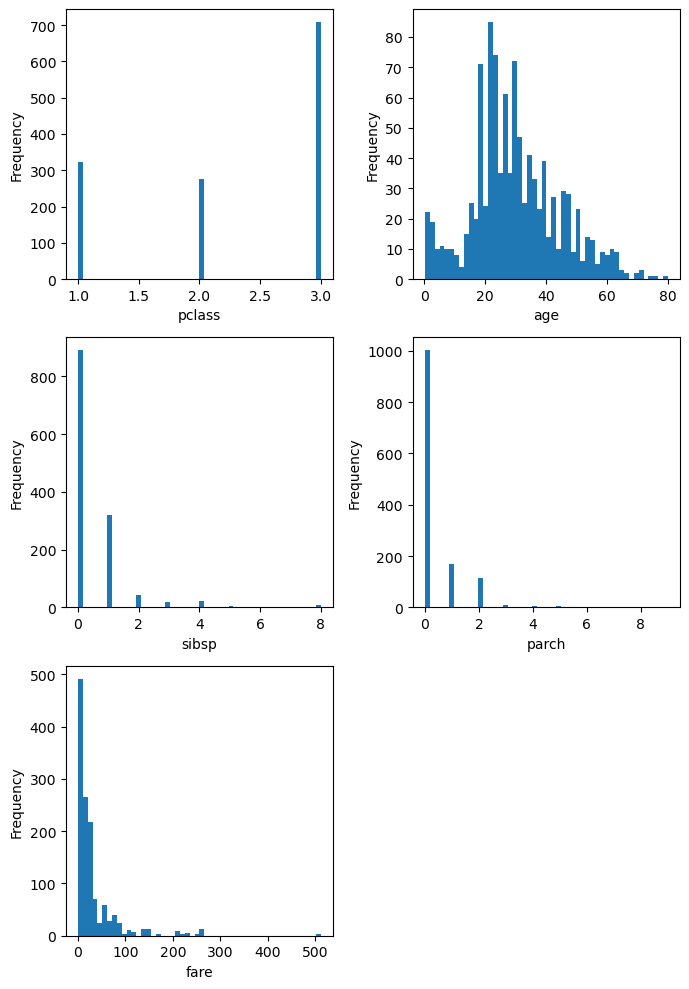

In [29]:
plt.figure(figsize=(7,10))

for i,c in enumerate(vars_num):
    ax = plt.subplot(3,2,i+1)
    data[c].plot.hist(ax=ax,bins=50)
    plt.xlabel(c)
plt.tight_layout()

In [29]:
from scipy import stats

In [30]:
data_cpy = data.copy()

In [31]:
for i,c in enumerate(vars_num):
    d, param = stats.yeojohnson(data_cpy[c])
    data_cpy[c] = d

BracketError: The algorithm terminated without finding a valid bracket. Consider trying different initial points.

In [ ]:
plt.figure()
for i,c in enumerate(vars_num):
    ax = plt.subplot(2,1,i+1)
    data_cpy[c].plot.hist(ax=ax,bins=50)
    plt.xlabel(c)
plt.tight_layout()

In [77]:
stats.yeojohnson(data[vars_num[1]])

(array([3.3940683 , 3.2679776 , 3.2679776 , ..., 1.74380223, 1.74380223,
        1.7948704 ]),
 -0.18570215913302957)

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [33]:
X_train["cabin"] = X_train.cabin.apply(lambda x: "Missing" if x is np.nan else x[:1])
X_test["cabin"] = X_test.cabin.apply(lambda x: "Missing" if x is np.nan else x[:1])

### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [34]:
vars_num_missing = X_train[vars_num].columns[X_train[vars_num].isnull().sum(axis=0)>0]
vars_num_missing_med = X_train[vars_num_missing].median()

missing_ind = X_train[vars_num_missing].isnull().astype(int)\
                .rename(columns={c:f"{c}_missing" for c in vars_num_missing})
X_train = pd.concat((X_train,missing_ind),axis=1).fillna(vars_num_missing_med)

missing_ind = X_test[vars_num_missing].isnull().astype(int)\
                .rename(columns={c:f"{c}_missing" for c in vars_num_missing})
X_test = pd.concat((X_test,missing_ind),axis=1).fillna(vars_num_missing_med)

In [35]:
X_train[vars_num].isnull().sum(axis=0)

pclass    0
age       0
sibsp     0
parch     0
fare      0
dtype: int64

In [36]:
X_test[vars_num].isnull().sum(axis=0)

pclass    0
age       0
sibsp     0
parch     0
fare      0
dtype: int64

### Replace Missing data in categorical variables with the string **Missing**

In [37]:
X_train["embarked"] = X_train.embarked.fillna("Missing")
X_test["embarked"] = X_test.embarked.fillna("Missing")

In [38]:
X_train[vars_cat].isnull().sum(axis=0)

sex         0
cabin       0
embarked    0
title       0
dtype: int64

In [39]:
X_test[vars_cat].isnull().sum(axis=0)

sex         0
cabin       0
embarked    0
title       0
dtype: int64

### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [40]:
cat_card = {}
X_train_labels = []
X_test_labels = []
for c in vars_cat:
    cat_card[c] = X_train[c].nunique()
    X_train_labels.append(X_train[c].drop_duplicates())
    X_test_labels.append(X_test[c].drop_duplicates())
cat_card = pd.Series(cat_card)
cat_card

sex         2
cabin       9
embarked    4
title       5
dtype: int64

In [41]:
for c in vars_cat:
    d = X_train.groupby(c).size()/X_train[c].size
    if d[d<.05].index.size>0:
        X_train[c] = X_train[c].apply(lambda x: "NA" if x in d[d<.05].index else x)
        X_test[c] = X_test[c].apply(lambda x: "NA" if x in d[d<.05].index else x)

In [42]:
cat_card = {}
X_train_labels = []
X_test_labels = []
for c in vars_cat:
    cat_card[c] = X_train[c].nunique()
    X_train_labels.append(X_train[c].drop_duplicates())
    X_test_labels.append(X_test[c].drop_duplicates())
cat_card = pd.Series(cat_card)
cat_card

sex         2
cabin       3
embarked    4
title       4
dtype: int64

### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [43]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [44]:
for c in vars_cat:
    print(c)
    onehot = OneHotEncoder()
    onehot.fit(X_train[[c]].astype(str))

    mat = onehot.transform(X_train[[c]].astype(str)).todense()[:,:-1]
    mat = pd.DataFrame(mat,columns=[f"{c}_{i}" for i in range(mat.shape[1])], index=X_train.index)
    X_train = pd.concat((X_train.drop(columns=[c]),mat),axis=1)
    
    mat = onehot.transform(X_test[[c]].astype(str)).todense()[:,:-1]
    mat = pd.DataFrame(mat,columns=[f"{c}_{i}" for i in range(mat.shape[1])], index=X_test.index)
    X_test = pd.concat((X_test.drop(columns=[c]),mat),axis=1)

sex
cabin
embarked
title


### Scale the variables

- Use the standard scaler from Scikit-learn

In [45]:
from scipy import stats

In [46]:
vars_cont = ["age", "fare"]

In [47]:
for c in vars_cont:
    d, param = stats.yeojohnson(X_train[c])
    X_train[c] = d
    d = stats.yeojohnson(X_test[c], lmbda=param)
    X_test[c] = d

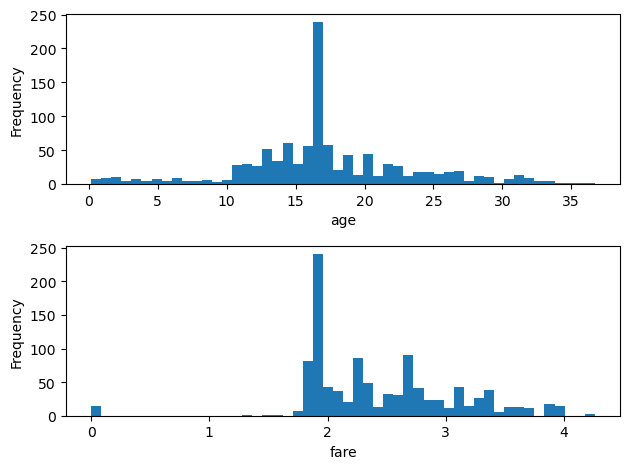

In [48]:
plt.figure()
for i,c in enumerate(vars_cont):
    ax = plt.subplot(2,1,i+1)
    X_train[c].plot.hist(ax=ax,bins=50)
    plt.xlabel(c)
plt.tight_layout()

In [49]:
scaler = StandardScaler().fit(X_train[vars_cont])

X_train[vars_cont] = scaler.transform(X_train[vars_cont])
X_test[vars_cont] = scaler.transform(X_test[vars_cont])

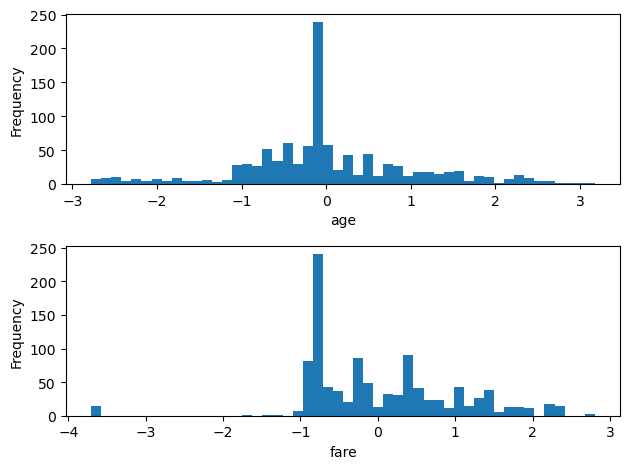

In [50]:
plt.figure()
for i,c in enumerate(vars_cont):
    ax = plt.subplot(2,1,i+1)
    X_train[c].plot.hist(ax=ax,bins=50)
    plt.xlabel(c)
plt.tight_layout()

## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [52]:
X_train[["embarked_0","embarked_1","embarked_2"]]

,embarked_0,embarked_1,embarked_2
1118,0.0,0.0,0.0
44,1.0,0.0,0.0
1072,0.0,0.0,1.0
1130,0.0,0.0,0.0
574,0.0,0.0,0.0
...,...,...,...
763,0.0,0.0,0.0
835,0.0,0.0,0.0
1216,0.0,0.0,1.0
559,0.0,0.0,0.0


In [145]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 

In [251]:
model = LogisticRegression().fit(X_train,y_train)

In [252]:
# make predictions for test set
class_ = model.predict(X_train)
pred = model.predict_proba(X_train)[:,1]

# determine mse and rmse
print('train roc-auc: {}'.format(roc_auc_score(y_train, pred)))
print('train accuracy: {}'.format(accuracy_score(y_train, class_)))
print()

# make predictions for test set
class_ = model.predict(X_test)
pred = model.predict_proba(X_test)[:,1]

# determine mse and rmse
print('test roc-auc: {}'.format(roc_auc_score(y_test, pred)))
print('test accuracy: {}'.format(accuracy_score(y_test, class_)))
print()

train roc-auc: 0.8597256568778979
train accuracy: 0.8147086914995224

test roc-auc: 0.8583641975308642
test accuracy: 0.8053435114503816



In [269]:
model = RandomForestClassifier().fit(X_train,y_train)

In [270]:
# make predictions for test set
class_ = model.predict(X_train)
pred = model.predict_proba(X_train)[:,1]

# determine mse and rmse
print('train roc-auc: {}'.format(roc_auc_score(y_train, pred)))
print('train accuracy: {}'.format(accuracy_score(y_train, class_)))
print()

# make predictions for test set
class_ = model.predict(X_test)
pred = model.predict_proba(X_test)[:,1]

# determine mse and rmse
print('test roc-auc: {}'.format(roc_auc_score(y_test, pred)))
print('test accuracy: {}'.format(accuracy_score(y_test, class_)))
print()

train roc-auc: 0.9967156105100464
train accuracy: 0.9770773638968482

test roc-auc: 0.8315740740740741
test accuracy: 0.8091603053435115



In [271]:
pred = model.predict_proba(X_test)

In [272]:
FPR = [((pred[:,1]>t).astype(int)[y_test==0]).sum()/(y_test==0).sum() for t in np.linspace(0,1,100)]

TPR = [((pred[:,1]>t).astype(int)[y_test==1]).sum()/(y_test==1).sum() for t in np.linspace(0,1,100)]

In [273]:
AUC_df = pd.DataFrame(np.array([FPR,TPR]).T,columns=["FPR","TPR"])\
            .sort_values("FPR").drop_duplicates().reset_index(drop=True)

In [274]:
AUC_df = pd.concat((AUC_df, pd.DataFrame([[1.0,AUC_df["TPR"].iloc[-1]]],columns=AUC_df.columns) ))

In [283]:
(((AUC_df.FPR.diff(1).fillna(0) - AUC_df.FPR.diff(-1).fillna(0))/2)*AUC_df.TPR).sum()

0.8279938271604939

In [276]:
((- AUC_df.FPR.diff(-1))*AUC_df.TPR).sum()

0.823641975308642

In [279]:
((AUC_df.FPR.diff(1))*AUC_df.TPR).sum()

0.8323456790123457

<Axes: xlabel='FPR'>

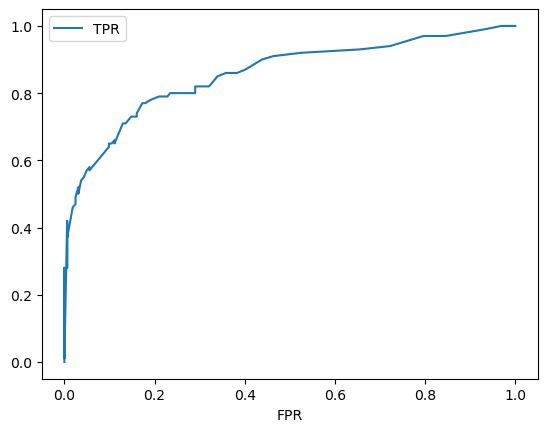

In [260]:
plt.figure()
ax = plt.gca()

AUC_df.set_index("FPR").plot(ax=ax)

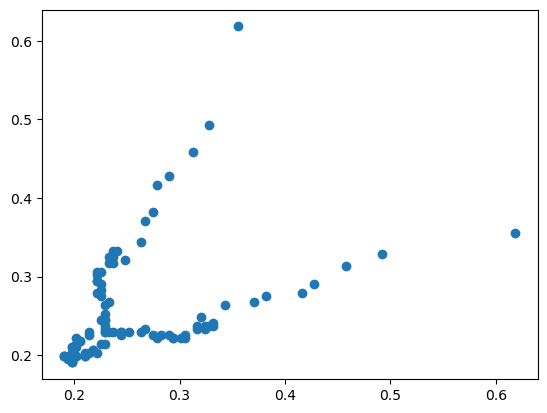

In [186]:
plt.figure()
ax = plt.gca()


ax.scatter(x0,x1)

In [174]:
(y_test - pred[:,1]).sum()/262

0.019353095260019555

In [169]:
sum([((pred[:,1]>t).astype(int) == y_test).sum()/y_test.size for t in np.linspace(0,1,1000)])/1000

0.7432290076335869

In [158]:
X_test.shape

(262, 16)

In [157]:
pred.shape

(262, 2)

In [284]:
from sklearn.metrics import det_curve

In [285]:
det_curve(y_test, pred[:,1])

(array([1.        , 0.82716049, 0.82098765, 0.75925926, 0.75308642,
        0.74691358, 0.70987654, 0.7037037 , 0.69753086, 0.69135802,
        0.68518519, 0.67901235, 0.67283951, 0.66666667, 0.66049383,
        0.60493827, 0.59876543, 0.56790123, 0.54938272, 0.54320988,
        0.53703704, 0.5308642 , 0.52469136, 0.51234568, 0.50617284,
        0.5       , 0.49382716, 0.48765432, 0.48148148, 0.4691358 ,
        0.46296296, 0.45679012, 0.45061728, 0.45061728, 0.44444444,
        0.4382716 , 0.42592593, 0.41975309, 0.41358025, 0.39506173,
        0.38271605, 0.38271605, 0.37037037, 0.36419753, 0.35802469,
        0.35185185, 0.35185185, 0.34567901, 0.32716049, 0.31481481,
        0.30864198, 0.30246914, 0.28395062, 0.27777778, 0.27160494,
        0.2654321 , 0.25925926, 0.25308642, 0.24074074, 0.22839506,
        0.21604938, 0.20987654, 0.2037037 , 0.19753086, 0.19753086,
        0.17901235, 0.17283951, 0.17283951, 0.16666667, 0.15432099,
        0.15432099, 0.14814815, 0.14197531, 0.14

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**

In [13]:
X_train

NameError: name 'X_train' is not defined